<a href="https://colab.research.google.com/github/chelynl/Machine_Learning/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering
- determine which features are the most important with mutual information
- invent new features in several real-world problem domains
- encode high-cardinality categoricals with a target encoding
- create segmentation features with k-means clustering
- decompose a dataset's variation into features with principal component analysis

<u>Purpose:</u>
- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results

## Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

**Goal**: predict concrete strength

In [ ]:
concrete = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ML concepts/Features   Pipelines/Concrete_Data.xls')
concrete

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [ ]:
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [ ]:
concrete.describe()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


Create baseline model with original features to see if any of them are useful.

In [ ]:
# Define inputs and target
X = concrete.copy().iloc[:,:-1]
y = concrete.copy().iloc[:,-1]

In [ ]:
# Baseline model
baseline_rf = RandomForestRegressor(criterion='mae', random_state=0)

# Use 5-fold CV to get average error score
baseline_score = cross_val_score(
    baseline_rf, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = np.abs(baseline_score.mean())

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.397


Creating new features (using ratios) to predict concrete strength.

In [ ]:
# Create synthetic features
X["FCRatio"] = X.iloc[:,-2] / X.iloc[:,-3] # fine to coarse aggregate ratio
X["AggCmtRatio"] = (X.iloc[:,-2] + X.iloc[:,-3]) / X.iloc[:,0] # total aggregate to cement ratio
X["WtrCmtRatio"] = X.iloc[:,3] / X.iloc[:,0] # water to cement ratio

In [ ]:
X

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),FCRatio,AggCmtRatio,WtrCmtRatio
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,0.650000,1.303704,0.300000
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,0.640758,1.303704,0.300000
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,0.637339,2.598496,0.685714
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,0.637339,2.884211,0.685714
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,0.843724,5.969285,0.966767
...,...,...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,0.883002,2.880970,0.649783
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,0.994498,2.611421,0.608318
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,0.874048,5.441077,1.297643
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,0.797191,5.134507,1.103708


In [ ]:
# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="mae", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = np.abs(score.mean())

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 8.212


Model performance improved slightly by adding ratios.
***

# Mutual Information

Rank features by their *strength of associations* to the target (feature utility metric) to focus and develop on relevant features.

**Mutual information (MI)** is a good metric to used compared to correlation because it can detect ANY relationship whereas correlation only detects linear relationships. Calculating MI is great starting point if you have not decided what model to use yet.
- describes relationships in terms of "uncertainty" (entropy)
- univariate metric (cannot detect significant interactions)
- MI=0 means no relationship between feature and target (MI>2 is super rare)
- actual usefulness of a feature depends on the model you choose (you need to transform the feature first to expose the association)

In [31]:
autos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/Features   Pipelines/Automobile_data.csv')
autos # we are predicting price of cars

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.4,23.0,106,4800,26,27,22470


We can see "?" values for missing data. We need to either impute or drop them.

In [32]:
# See variable types
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [33]:
# Convert "?" to NaN
autos = autos.replace('?', np.nan)

# See which columns have missing values
nan_df = autos.loc[:,autos.isna().sum()>0]
print('Number of missing values:', '\n\n', nan_df.isna().sum())

"""
After investigating each var, "normalized-losses" has almost 20% missing data
whereas the other vars have about 1-2% missing data (also their missing values
tend to overlap with each other). Thus, we will drop missing values for all 
vars except "normalized-losses". We will impute remaining missing values.
"""

cols_to_drop_missing = list(nan_df.iloc[:,1:].columns)

indexes_to_remove = []

for col in cols_to_drop_missing:
  for i in autos[(autos[col].isna())].index:
    if i not in indexes_to_remove:
      indexes_to_remove.append(i)

autos = autos.drop(indexes_to_remove)
autos

Number of missing values: 

 normalized-losses    41
num-of-doors          2
bore                  4
stroke                4
horsepower            2
peak-rpm              2
price                 4
dtype: int64


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.4,23.0,106,4800,26,27,22470


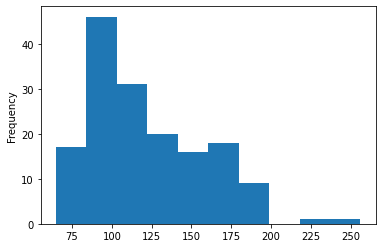

In [34]:
# See histogram of "normalized-loss" to determine method to impute: median!
autos['normalized-losses'].astype(float).plot(kind='hist')

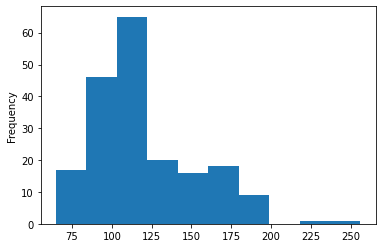

In [35]:
# Instantiate imputer
imputer = SimpleImputer(strategy='median')

# Impute missing values with median
autos['normalized-losses'] = imputer.fit_transform(autos['normalized-losses'].values.reshape(-1,1))
autos['normalized-losses'].plot(kind='hist') # confirm histogram again

Sklearn treats `continuous` and `discrete` variables differently for its MI algorithm, so you need to tell it which are which. `Categorical` variables can be treated as discrete after label encoding them (label encoding works best for ordinal variables since we are assigning unique integers). *Rule of thumb*: anything that MUST be a float is not discrete.

Also convert our target from object type to int type.

In [36]:
# Convert target type to int
autos['price'] = autos['price'].astype(int)

In [37]:
# Define inputs and target
X = autos.copy().iloc[:,:-1]
y = autos.copy().iloc[:,-1]

In [38]:
# Label encoding for categoricals
for col in X.select_dtypes("object"):
  # assign numeric labels back to col 
  X[col], _ = X[col].factorize()

# Discrete features should now have int dtypes
discrete_features = X.dtypes==int
X.loc[:,discrete_features]

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,horsepower,peak-rpm,city-mpg,highway-mpg
0,3,0,0,0,0,0,0,0,2548,0,0,130,0,0,0,0,0,21,27
1,3,0,0,0,0,0,0,0,2548,0,0,130,0,0,0,0,0,21,27
2,1,0,0,0,0,1,0,0,2823,1,1,152,0,1,1,1,0,19,26
3,2,1,0,0,1,2,1,0,2337,2,0,109,0,2,2,2,1,24,30
4,2,1,0,0,1,2,2,0,2824,2,2,136,0,2,2,3,1,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,20,0,0,1,2,0,0,2952,2,0,141,0,23,16,52,4,23,28
201,-1,20,0,1,1,2,0,0,3049,2,0,141,0,23,16,35,20,19,25
202,-1,20,0,0,1,2,0,0,3012,1,1,173,0,20,35,54,1,18,23
203,-1,20,1,1,1,2,0,0,3217,2,1,145,5,37,2,55,6,26,27


Sklearn has two mutual information metrics in its *feature_selection* module:
- **mutual_info_regression**
 - use for real-valued targets
- **mutual_info_classif**
 - use for categorical targets

Our target, `price`, is real-valued.

In [39]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
  # Get MI scores per col
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
  # Put scores in series and sort in descending order
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

curb-weight          1.540327
horsepower           1.259333
engine-size          1.006284
highway-mpg          0.957432
city-mpg             0.859776
stroke               0.732968
bore                 0.700650
width                0.668208
length               0.613819
wheel-base           0.592102
make                 0.544727
fuel-system          0.484248
peak-rpm             0.448826
height               0.358069
drive-wheels         0.333127
num-of-cylinders     0.332900
normalized-losses    0.268367
symboling            0.228642
compression-ratio    0.169787
engine-type          0.149994
aspiration           0.087994
body-style           0.079130
fuel-type            0.047279
engine-location      0.036336
num-of-doors         0.010938
Name: MI Scores, dtype: float64

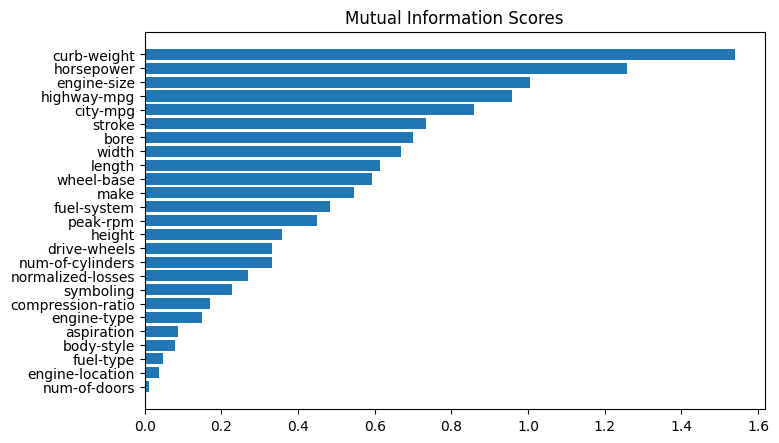

In [40]:
# Visualize MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

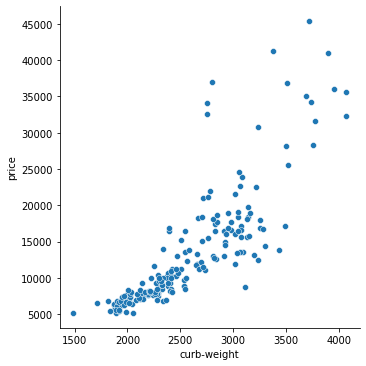

In [41]:
# Confirm that curb-weight is a useful feature (definitely seems to be a relationship)
sns.relplot(x="curb-weight", y="price", data=autos)

From the bar chart, it looks like fuel type is not that important. However, you can clearly see 2 distinct groups within price with varying horsepower. The plot below shows that fuel type contributes an interaction effect and might not be unimportant afterall. Thus, it is super important to investigate potential interactions before deciding on variable importance solely based on MI. Domain knowledge is great for guiding this process.

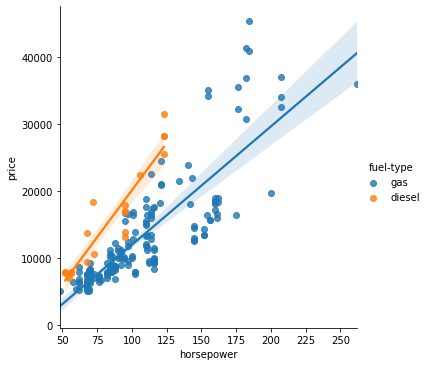

In [42]:
# Convert obj to int type for plotting
autos.horsepower = autos.horsepower.astype(int)
# Plot horsepower vs. price color-coded by fuel type
sns.lmplot(x='horsepower', y='price', hue='fuel-type', data=autos)

# Creating Features

Data visualization can suggest transformations ("reshaping" of a feature) through powers or logarithms. <br>
Ex/ Take natural log of a variable that is highly skewed to normalize the distribution.
-  If the feature has 0 values, use `np.log1p` (log(1+x)) instead of `np.log`

You can create features using <b>mathematical transformations</b>:
- Ex/ Taking the ratio of two variables

In [43]:
# Make sure both vars are numeric types
autos.stroke = autos.stroke.astype(float)
autos.bore = autos.bore.astype(float)

# Create a new var that takes the ratio between stroke and bore
autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult it will be for a model to learn such as displacement formula below:

In [44]:
# Number of cylinders are words instead of integers
autos['num-of-cylinders'].unique()

array(['four', 'six', 'five', 'three', 'twelve', 'eight'], dtype=object)

In [45]:
# Dict to map words to integers
num_dict = {'three': 3,
            'four': 4,
            'five': 5,
            'six': 6,
            'eight': 8,
            'twelve': 12}

# Replace words with integers using dict
autos['num-of-cylinders'] = autos['num-of-cylinders'].map(num_dict)

In [46]:
# Confirm results
autos['num-of-cylinders']

0      4
1      4
2      6
3      4
4      5
      ..
200    4
201    4
202    6
203    6
204    4
Name: num-of-cylinders, Length: 193, dtype: int64

In [47]:
# Create new feature (more difficult formula means longer training period)
autos["displacement"] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos['num-of-cylinders']
)

# Confirm results
autos['displacement']

0      101.377976
1      101.377976
2      117.446531
3      108.695147
4      135.868934
          ...    
200    141.398247
201    141.398247
202    173.336124
203    145.162032
204    141.398247
Name: displacement, Length: 193, dtype: float64

Data viz can help with deciding which transformation to use.

In [ ]:
accidents = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/Features   Pipelines/US_Accidents_Dec20_Updated.csv')
accidents.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,2,2019-05-21 08:29:55,2019-05-21 09:29:40,34.808868,-82.269157,34.808868,-82.269157,0.0,Accident on Tanner Rd at Pennbrooke Ln.,439.0,Tanner Rd,R,Greenville,Greenville,SC,29607-6027,US,US/Eastern,KGMU,2019-05-21 08:53:00,76.0,76.0,52.0,28.91,10.0,N,7.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,A-2,2,2019-10-07 17:43:09,2019-10-07 19:42:50,35.090080,-80.745560,35.090080,-80.745560,0.0,Accident on Houston Branch Rd at Providence Br...,3299.0,Providence Branch Ln,R,Charlotte,Mecklenburg,NC,28270-8560,US,US/Eastern,KEQY,2019-10-07 17:53:00,76.0,76.0,62.0,29.30,10.0,VAR,3.0,0.0,Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,A-3,2,2020-12-13 21:53:00,2020-12-13 22:44:00,37.145730,-121.985052,37.165850,-121.988062,1.4,Stationary traffic on CA-17 from Summit Rd (CA...,NaN,Santa Cruz Hwy,R,Los Gatos,Santa Clara,CA,95033,US,US/Pacific,KSJC,2020-12-13 21:53:00,51.0,51.0,80.0,30.17,10.0,W,6.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
3,A-4,2,2018-04-17 16:51:23,2018-04-17 17:50:46,39.110390,-119.773781,39.110390,-119.773781,0.0,Accident on US-395 Southbound at Topsy Ln.,NaN,US Highway 395 S,R,Carson City,Douglas,NV,89705,US,US/Pacific,KCXP,2018-04-17 16:55:00,53.6,NaN,16.0,30.16,10.0,SSW,4.6,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
4,A-5,3,2016-08-31 17:40:49,2016-08-31 18:10:49,26.102942,-80.265091,26.102942,-80.265091,0.0,Accident on I-595 Westbound at Exit 4 / Pine I...,NaN,I-595 W,R,Fort Lauderdale,Broward,FL,33324,US,US/Eastern,KHWO,2016-08-31 17:53:00,84.2,NaN,84.0,29.92,10.0,SSE,13.8,NaN,Overcast,False,False,False,False,True,False,False,False,False,False,False,True,False,Day,Day,Day,Day


### EDA

In [ ]:
accidents.shape

(2906610, 47)

In [ ]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906610 entries, 0 to 2906609
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Number                 float64
 11  Street                 object 
 12  Side                   object 
 13  City                   object 
 14  County                 object 
 15  State                  object 
 16  Zipcode                object 
 17  Country                object 
 18  Timezone               object 
 19  Airport_Code           object 
 20  Weather_Timestamp      object 
 21  Temperature(F)         float64
 22  Wind_Chill(F)     

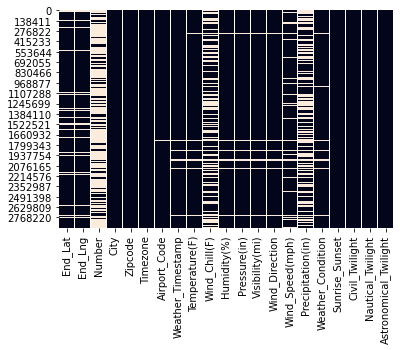

In [ ]:
# Identify columns with missing values
missing_cols = accidents.columns[accidents.isna().any()]

# len(missing_cols) # 21 cols have at least 1 missing value

# visualize number of missing values for each col (tan is missing)
sns.heatmap(accidents[missing_cols].isna(), cbar=False)

Drop columns with more than 30% missing values and impute remaining

In [ ]:
cols_to_impute = []
cols_to_drop = []

for col in accidents[missing_cols]:
    
    # identify cols to impute
    if accidents[col].isnull().sum() / accidents.shape[0] < 0.3:
        cols_to_impute.append(col)
    
    # identify cols to drop (or make "missing" level)
    else:
        cols_to_drop.append(col)

print('Columns to impute:', len(cols_to_impute))
print('Columns to drop/make missing level:', len(cols_to_drop))

Columns to impute: 18
Columns to drop/make missing level: 3


In [ ]:
# all variables in cols_to_drop are numeric --> just drop
accidents = accidents.drop(columns=cols_to_drop)
accidents.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,2,2019-05-21 08:29:55,2019-05-21 09:29:40,34.808868,-82.269157,34.808868,-82.269157,0.0,Accident on Tanner Rd at Pennbrooke Ln.,Tanner Rd,R,Greenville,Greenville,SC,29607-6027,US,US/Eastern,KGMU,2019-05-21 08:53:00,76.0,52.0,28.91,10.0,N,7.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,A-2,2,2019-10-07 17:43:09,2019-10-07 19:42:50,35.090080,-80.745560,35.090080,-80.745560,0.0,Accident on Houston Branch Rd at Providence Br...,Providence Branch Ln,R,Charlotte,Mecklenburg,NC,28270-8560,US,US/Eastern,KEQY,2019-10-07 17:53:00,76.0,62.0,29.30,10.0,VAR,3.0,Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,A-3,2,2020-12-13 21:53:00,2020-12-13 22:44:00,37.145730,-121.985052,37.165850,-121.988062,1.4,Stationary traffic on CA-17 from Summit Rd (CA...,Santa Cruz Hwy,R,Los Gatos,Santa Clara,CA,95033,US,US/Pacific,KSJC,2020-12-13 21:53:00,51.0,80.0,30.17,10.0,W,6.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
3,A-4,2,2018-04-17 16:51:23,2018-04-17 17:50:46,39.110390,-119.773781,39.110390,-119.773781,0.0,Accident on US-395 Southbound at Topsy Ln.,US Highway 395 S,R,Carson City,Douglas,NV,89705,US,US/Pacific,KCXP,2018-04-17 16:55:00,53.6,16.0,30.16,10.0,SSW,4.6,Clear,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
4,A-5,3,2016-08-31 17:40:49,2016-08-31 18:10:49,26.102942,-80.265091,26.102942,-80.265091,0.0,Accident on I-595 Westbound at Exit 4 / Pine I...,I-595 W,R,Fort Lauderdale,Broward,FL,33324,US,US/Eastern,KHWO,2016-08-31 17:53:00,84.2,84.0,29.92,10.0,SSE,13.8,Overcast,False,False,False,False,True,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [ ]:
# See var type for columns to impute
accidents[cols_to_impute].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906610 entries, 0 to 2906609
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   End_Lat                float64
 1   End_Lng                float64
 2   City                   object 
 3   Zipcode                object 
 4   Timezone               object 
 5   Airport_Code           object 
 6   Weather_Timestamp      object 
 7   Temperature(F)         float64
 8   Humidity(%)            float64
 9   Pressure(in)           float64
 10  Visibility(mi)         float64
 11  Wind_Direction         object 
 12  Wind_Speed(mph)        float64
 13  Weather_Condition      object 
 14  Sunrise_Sunset         object 
 15  Civil_Twilight         object 
 16  Nautical_Twilight      object 
 17  Astronomical_Twilight  object 
dtypes: float64(7), object(11)
memory usage: 399.2+ MB


In [ ]:
# Categorize categorical and numeric vars
cat_vars = []
num_vars = []

for col in cols_to_impute:
  if accidents[col].dtype==object:
    cat_vars.append(col)
  else:
    num_vars.append(col)

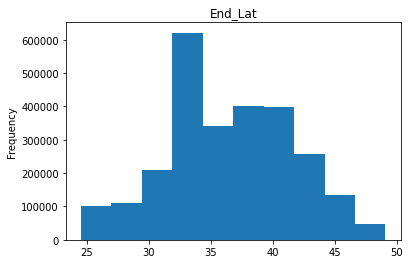

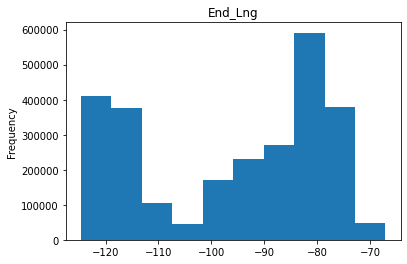

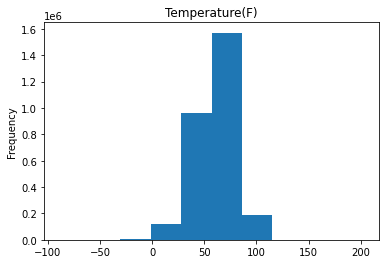

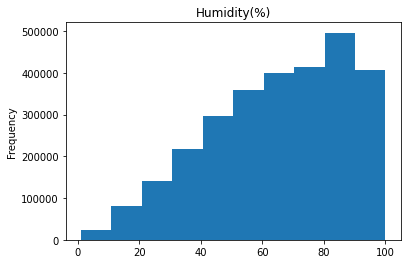

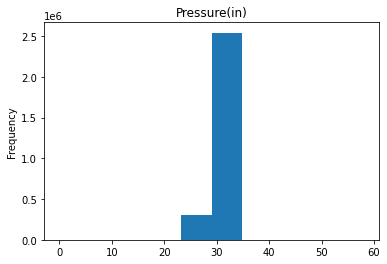

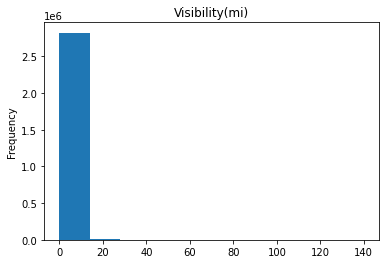

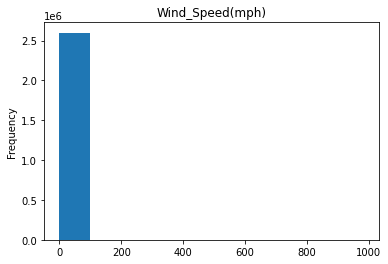

In [ ]:
# Plot numeric vars to determine best impute method and identify skewed vars
for var in num_vars:
  accidents[var].plot(kind='hist')
  plt.title(f'{var}')
  plt.show()

`Wind Speed` and `Visibility` are highly skewed and thus, we will transform them by taking the natural log (adding 1 to avoid logging 0s).

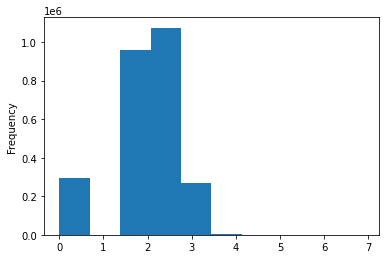

In [ ]:
accidents['Log Wind_Speed(mph)'] = np.log1p(accidents['Wind_Speed(mph)'])
accidents['Log Wind_Speed(mph)'].plot(kind='hist')

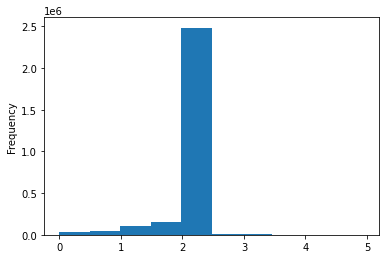

In [ ]:
accidents['Log Visibility(mi)'] = np.log1p(accidents['Visibility(mi)'])
accidents['Log Visibility(mi)'].plot(kind='hist')

Features to impute using mean:
- Visibility
- Pressure
- Temperature

Features to impute using median:
- Wind speed
- Humidity

Features to impute with "missing" flag:
- Wind direction
- Weather condition
- Sunrise sunset
- Civil twilight
- Nautical twilight
- Astronomical twilight

Features to drop:
- City
- Zipcode
- Timezone
- Airport code
- Weather timestamp
- End Longitude
- End Latitude


### Use <b>counts</b> to create a new feature:
- Ex/ Number of roadway features

In [ ]:
roadway_features = ["Amenity", "Bump", "Crossing", "Give_Way",
                    "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop",
                    "Traffic_Calming", "Traffic_Signal"]

accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,True,1
4,False,False,False,False,True,False,False,False,False,False,False,True,2
5,False,False,False,False,False,False,False,False,False,False,False,False,0
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,False,False,False,False,False,False,False,False,False,False,0
8,False,False,False,False,False,False,False,False,False,False,False,False,0
9,False,False,False,False,False,False,False,False,False,False,False,False,0


### Create a new feature that checks whether the value of each column is <b>greater than</b> 0.

In [ ]:
# Rename columns to make easier to wrangle
concrete.columns = ['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer', 'CoarseAggregate', 'FineAggregate', 'Age', 'ConcreteStrength']

In [ ]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
               
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


### Building up and breaking down features

In [ ]:
customer = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/Features   Pipelines/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')
customer.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


Create 2 new features from `Policy` column.

In [ ]:
customer.Policy

0       Corporate L3
1        Personal L3
2        Personal L3
3       Corporate L2
4        Personal L1
            ...     
9129     Personal L1
9130    Corporate L3
9131    Corporate L2
9132     Personal L2
9133    Corporate L3
Name: Policy, Length: 9134, dtype: object

In [ ]:
# Split values on " " and expand=True to get 2 separate columns
customer[['Type', 'Level']] = customer.Policy.str.split(' ', expand=True)

customer[['Policy', 'Type', 'Level']].head()

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1


 <b>Join</b> simple features into a composed feature if you had reason to believe there was some <b>interaction</b> in the combination:       

In [ ]:
autos["make_and_style"] = autos["make"] + "_" + autos["body-style"]
autos[["make", "body-style", "make_and_style"]].head()

,make,body-style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


### Group Transforms

In [ ]:
# Create a new feature that shows the average income for that state
customer['AverageIncome'] = customer.groupby('State')['Income'].transform('mean')

customer[['State', 'Income', 'AverageIncome']].head()

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083


In [ ]:
# Create a new feature that shows the proportional state frequency
customer['StateFreq'] = customer.groupby('State')['State'].transform('count') / customer.shape[0]

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


In [ ]:
# Partition data
train_df = customer.sample(frac=0.5)
valid_df = customer.drop(train_df.index)

# Create the average claim amount by coverage type on the training set
train_df["AverageClaim"] = train_df.groupby("Coverage")["Total Claim Amount"].transform("mean")

# Merge the average values by coverage type to the validation set
valid_df = valid_df.merge(train_df[['Coverage', 'AverageClaim']].drop_duplicates(), on='Coverage', how='left')

valid_df[['Coverage', 'AverageClaim']].head()

,Coverage,AverageClaim
0,Extended,481.702858
1,Premium,662.468029
2,Basic,377.606228
3,Basic,377.606228
4,Premium,662.468029


# Clustering with K-Means 
### (partition data based on proximity)

You can use k-means clustering to find groups such as market segment or geographic areas (cluster labels) that can help ML models learn complex relationships of space or proximity. These labels can be used as a `categorical` variable.

Why use k-means for feature engineering?
- Clusters will break up complicated relationships across features into simpler chunks. Our model can then just learn the simpler chunks one-by-one instead having to learn the complicated whole all at once. ("divide and conquer" strategy)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/Features   Pipelines/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
X = df[['longitude', 'latitude', 'median_income']]

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,longitude,latitude,median_income,Cluster
0,-122.23,37.88,8.3252,3
1,-122.22,37.86,8.3014,3
2,-122.24,37.85,7.2574,3
3,-122.25,37.85,5.6431,3
4,-122.25,37.85,3.8462,0


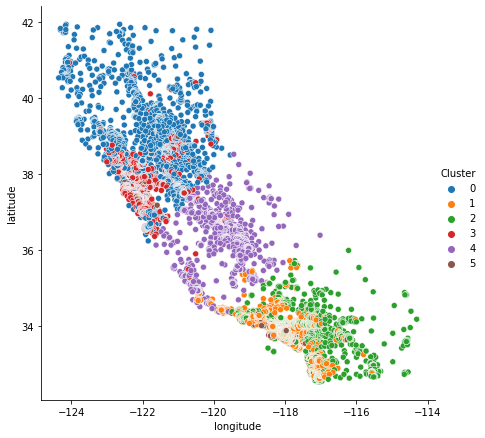

In [7]:
sns.relplot(x="longitude", y="latitude", hue="Cluster", data=X, height=6)

The plot shows the geographic distribution of the clusters. It seems like the algorithm has created separate segments for higher-income areas on the coasts.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


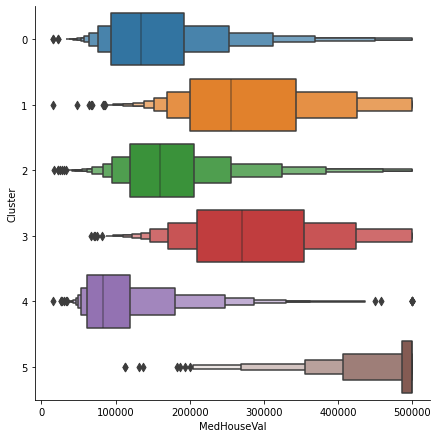

In [8]:
X["MedHouseVal"] = df["median_house_value"] # median house value is the target
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);

These box-plots show the distribution of the target within each cluster. If the clustering is informative, these distributions should, for the most part, separate across MedHouseVal, which is indeed what we see.

# PCA
### (partition data based on variation)

<u><b>2 ways to use PCA for feature engineering</b></u>
- Descriptive technique to determine what features to create
 - You can compute MI scores for PCs and see what kind of variation is most predictive of the target.
 - You can even try clustering on one or most of the higher PCs
- Use PCs as features directly (some use cases below)
 - `Dimensionality reduction`: PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
 - `Anomaly detection`: you can find unusual variation that's not apparent from the original features (often show up in the low-variance components). These PCs can be informative for detecting outliers or anomalies in the data.
 - `Noise reduction`: PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
 - `Decorrelation`: PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

In [49]:
features = ["highway-mpg", "engine-size", "horsepower", "curb-weight"]

y = autos.price
X = autos.loc[:, features]

# Standardize data before PCA
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [73]:
from sklearn.decomposition import PCA

# Define number of components to be used for PCA
pca = PCA(n_components=4)
scores = pca.fit_transform(X_scaled)
loadings = pca.components_.T

# Convert scores to df
component_names = [f"PC{i+1}" for i in range(scores.shape[1])]

scores_df = pd.DataFrame(scores, columns=component_names)
loadings_df = pd.DataFrame(loadings, columns=component_names, index=X.columns)

In [78]:
scores_df

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138
...,...,...,...,...
188,0.869097,-0.033610,-0.322867,-0.169687
189,1.784896,-0.335345,0.407270,-0.652607
190,1.938892,-0.096703,-0.051044,0.275515
191,1.137520,-0.032469,-0.826623,-0.219731


In [77]:
loadings_df

,PC1,PC2,PC3,PC4
highway-mpg,-0.492347,0.770892,0.070142,-0.397996
engine-size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb-weight,0.503262,0.113008,-0.678369,-0.523232


Signs and magnitudes of a PC's loadings tell us what kind of variation it's captured.

In [80]:
# Explained Variance per PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))

# Combine df of PC, explained variance, cumulative variance
pc_df = pd.DataFrame(component_names, columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])
df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)

df_explained_variance

,PC,Explained Variance,Cumulative Variance
0,PC1,0.854114,0.854
1,PC2,0.066489,0.920
2,PC3,0.059495,0.979
3,PC4,0.019902,0.999


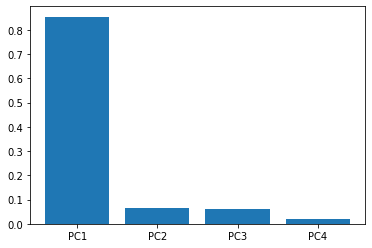

In [84]:
plt.bar(x='PC', height='Explained Variance', data=df_explained_variance)
plt.show()

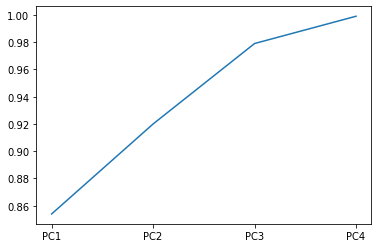

In [86]:
plt.plot(df_explained_variance['PC'], df_explained_variance['Cumulative Variance'])
plt.show()

Text(0, 0.5, 'Eigenvalue')

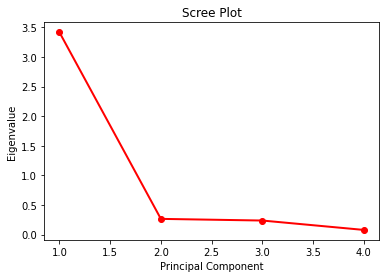

In [82]:
PC_vals = np.arange(4) + 1
plt.plot(PC_vals, pca.explained_variance_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

In [53]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.014661
PC2    0.379637
PC3    0.306483
PC4    0.205228
Name: MI Scores, dtype: float64

In [89]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body-style", "horsepower", "curb-weight"]
autos.iloc[idx][cols]

,make,body-style,horsepower,curb-weight
126,porsche,hardtop,207,2756
127,porsche,hardtop,207,2756
128,porsche,convertible,207,2800
49,jaguar,sedan,262,3950
105,nissan,hatchback,200,3139
...,...,...,...,...
68,mercedes-benz,wagon,123,3750
70,mercedes-benz,sedan,123,3770
110,peugot,wagon,95,3430
114,peugot,wagon,95,3485


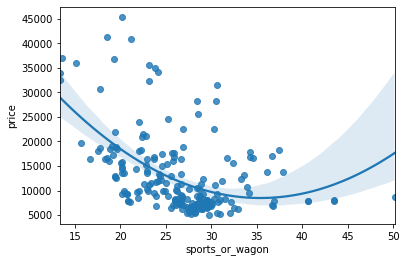

In [59]:
autos["sports_or_wagon"] = X['curb-weight'] / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=autos, order=2);